# King County Millenial homeowner program

**Buying a property in King County recommendations for Millennials**

**Authors:** Hanis Zulmuthi, Greg Burgess, Kyle Weesner

***March 2022***


<img src="https://www.condosky.com/wp-content/uploads/2019/06/Young-Families-Condos-Toronto-e1561577724820.jpg" alt="A picture of a multiracial family sitting on the floor together surrounded by moving boxes" title="" />

# Overview

King County in Washington State is growing in population made up of millenials and generation Z who either grew up or migrated to the area and found life in the region. We, the Data Analysts at the Greek Honey real estate are woking on building a model that predicts house prices in King county with the goal to help folks from the demographic to find their dream house that fits their lifestyle and their pockets! 

# ADD A SUMMARY OF RESULTS HERE

## Business Problem

Housing market in King County region, especially in the major cities such as Seattle, are becoming more and more financially inaccessible for many demographics. The demographic of interest for our real-estate is millenials who are building their career, family and trying to break into the housing market to have a stable housing for themselves. With our house price predicition model, we will help them to find the market value of their ideal house that are in proximity to city centers.

## Data Understanding

### 1. King County Housing data ([kc_house_data.csv](https://github.com/hanis-z/Phase-2-project/blob/main/data/kc_house_data.csv))
**Source:** This data was provided to us by Flatiron School. This data file is available in the project repo in the folder "data". 

**Contents:**

### 2. Incorporated & Unincorporated cities in King county
**Source:** We downloaded this data from [King County GIS website]( https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::cities-and-unincorporated-king-county-city-kc-area/explore?location=47.430582%2C-121.809200%2C10.02). The data is also easily accessible in our project repo in the folder "data".

**Contents:**

### 3. Neighborhood Map of Seattle
**Source:** We attained this data from [Seattle city GIS website](https://data-seattlecitygis.opendata.arcgis.com/datasets/neighborhood-map-atlas-districts/explore?location=47.628714%2C-122.338313%2C11.43]). This data is also easily accessible in our project repo in the folder "data".

**Contents:**


### Importing python libraries required for the analysis.

**Note:** To ensure that all packages are loaded successfully, please ensure that you are in the right python environment. For more reference, refer the (how-to-set-environment)[link to the file] to ensure you have the correct working environment to run this notebook.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#import fiona
#import geopandas as gpd
#from shapely.geometry import Point
#import pyproj
#import folium

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from pandas.api.types import is_numeric_dtype

### Define Helper Functions for analysis

In [2]:
def dataframe_info(df):
    '''
    Takes Pandas dataframe (df). Prints number of rows, number of columns, and three sample rows.
    Returns list of numerical columns and list of non-numerical columns.
    '''
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    object_cols  = df.select_dtypes(exclude=np.number).columns.tolist()

    nrows, ncol = df.shape
    nmid = nrows // 2
    
    print(f"Dimensions: {nrows} rows and {ncol} columns")
    print(f"Numeric columns: {len(numeric_cols)}")
    print(f"Object columns: {len(object_cols)}")

    display(df.iloc[[0,nmid,nrows-1]]) # show three rows: first, mid, and last

    return numeric_cols, object_cols

In [3]:
def cleaned_column_names(column_list):
    '''
    Takes list of column names (e.g. from df.columns). 
    Returns list of cleaned column names that can be assigned to DataFrame.
    Usage: df.columns = cleaned_column_names(df.columns)
    '''
    return [name.strip().lower().replace(' ','').replace('-', '_') for name in column_list]

## Data Exploration & Preparation


### Load King County Housing data

In [4]:
housing_df = pd.read_csv('../data/housing_gdf_complete.csv')
print(housing_df.columns)
housing_df.columns = cleaned_column_names(housing_df.columns)
print(housing_df.columns)


#housing_df= gpd.GeoDataFrame(housing_df, crs="EPSG:4326")

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'coord',
       'geometry', 'city', 'dist_seattle', 'neighborhood', 'in_seattle'],
      dtype='object')
Index(['unnamed:0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'coord',
       'geometry', 'city', 'dist_seattle', 'neighborhood', 'in_seattle'],
      dtype='object')


In [5]:
num, obj = dataframe_info(housing_df)

Dimensions: 21596 rows and 28 columns
Numeric columns: 17
Object columns: 11


,unnamed:0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,lat,long,sqft_living15,sqft_lot15,coord,geometry,city,dist_seattle,neighborhood,in_seattle
0,0,8856004730,9/17/2014,199950.0,2,2.75,1590,20917,1.5,NO,...,47.2786,-122.250,1310,6000,"(-122.25, 47.2786)",POINT (392815.9311460542 31962.040946318088),Algona,38586.298196,NaN,False
10798,10798,7237500590,11/17/2014,1320000.0,4,5.25,6110,10369,2.0,NO,...,47.5285,-122.135,4190,10762,"(-122.135, 47.5285)",POINT (401985.90108066204 59588.48465827319),Newcastle,19145.331588,NaN,False
21595,21595,9808100150,4/2/2015,3350000.0,5,3.75,5350,15360,1.0,NO,...,47.6480,-122.218,3740,15940,"(-122.218, 47.648)",POINT (395975.83394082234 72981.52286293103),Yarrow Point,10564.303190,NaN,False


In [6]:
housing_df['dist_seattle'] = housing_df['dist_seattle'] / 1609.34 #convert meters to miles

## Data Mapping

In [7]:
housing_df[num].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21596 entries, 0 to 21595
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unnamed:0      21596 non-null  int64  
 1   id             21596 non-null  int64  
 2   price          21596 non-null  float64
 3   bedrooms       21596 non-null  int64  
 4   bathrooms      21596 non-null  float64
 5   sqft_living    21596 non-null  int64  
 6   sqft_lot       21596 non-null  int64  
 7   floors         21596 non-null  float64
 8   sqft_above     21596 non-null  int64  
 9   yr_built       21596 non-null  int64  
 10  yr_renovated   17754 non-null  float64
 11  zipcode        21596 non-null  int64  
 12  lat            21596 non-null  float64
 13  long           21596 non-null  float64
 14  sqft_living15  21596 non-null  int64  
 15  sqft_lot15     21596 non-null  int64  
 16  dist_seattle   21596 non-null  float64
dtypes: float64(7), int64(10)
memory usage: 2.8 MB


In [8]:
housing_df[obj].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21596 entries, 0 to 21595
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           21596 non-null  object
 1   waterfront     19221 non-null  object
 2   view           21533 non-null  object
 3   condition      21596 non-null  object
 4   grade          21596 non-null  object
 5   sqft_basement  21596 non-null  object
 6   coord          21596 non-null  object
 7   geometry       21596 non-null  object
 8   city           21596 non-null  object
 9   neighborhood   6735 non-null   object
 10  in_seattle     21596 non-null  bool  
dtypes: bool(1), object(10)
memory usage: 1.7+ MB


## Data Cleaning

### Basement

In [9]:
# sqft_basement should equal difference between sqft_living and sqft_above
sqft_basement_computed = housing_df['sqft_living'] - housing_df['sqft_above']

housing_df['has_basement'] = (sqft_basement_computed > 0).astype(int)

### Yr renovated

In [10]:
housing_df['sold_dt'] = pd.to_datetime(housing_df['date'])
housing_df['sold_year'] = pd.DatetimeIndex(housing_df['sold_dt']).year
housing_df['sold_month'] = pd.DatetimeIndex(housing_df['sold_dt']).month

In [11]:
housing_df['yr_renovated_missing'] = (housing_df['yr_renovated'].isna()).astype(int)
housing_df['yr_renovated'].fillna(0, inplace=True)

housing_df['renovated'] = ((housing_df['sold_year'] - housing_df['yr_renovated']) <= 5).astype(int)

### Age of the house

In [12]:
housing_df['house_age'] = housing_df['sold_year'] - housing_df['yr_built']
housing_df['house_age'].describe()

count    21596.000000
mean        43.323810
std         29.377864
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: house_age, dtype: float64

### View

In [13]:
housing_df['view_missing'] = (housing_df['view'].isna()).astype(int)

In [14]:
housing_df['view'].fillna('NONE', inplace=True)

### Waterfront

In [15]:
housing_df['waterfront_missing'] = (housing_df['waterfront'].isna()).astype(int)
housing_df['waterfront'].fillna('NO', inplace=True)

### Duplicate records (house resold)

In [16]:
print(f"Number of rows:\t\t{len(housing_df['id'])}")
print(f"Number unique:\t\t{len(housing_df['id'].unique())}")
print(f"Number duplicates:\t{sum(housing_df['id'].duplicated() == True)}")

Number of rows:		21596
Number unique:		21419
Number duplicates:	177


In [17]:
housing_df = housing_df.sort_values(by=['sold_year', 'sold_month'])
housing_df['resold'] = housing_df.id.duplicated().astype(int)

### Fill NaNs in neighborhood column

In [18]:
housing_df['neighborhood'] = housing_df['neighborhood'].fillna('NA')

### Ratio between bedrooms and bathrooms

In [19]:
housing_df['br_bth'] = housing_df.bedrooms / housing_df.bathrooms

In [20]:
num,obj = dataframe_info(housing_df)

Dimensions: 21596 rows and 39 columns
Numeric columns: 27
Object columns: 12


,unnamed:0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sold_dt,sold_year,sold_month,yr_renovated_missing,renovated,house_age,view_missing,waterfront_missing,resold,br_bth
1,1,3356406510,5/30/2014,196440.0,3,2.0,1560,7352,1.0,NO,...,2014-05-30,2014,5,0,0,22,0,0,0,1.50
10749,10749,1023089197,10/7/2014,390000.0,3,2.0,1930,12443,1.0,NO,...,2014-10-07,2014,10,0,0,45,0,0,0,1.50
21594,21594,1925059254,5/7/2015,3000000.0,5,4.0,6670,16481,2.0,NO,...,2015-05-07,2015,5,1,0,8,0,0,0,1.25


In [21]:
housing_df[num].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 1 to 21594
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   unnamed:0             21596 non-null  int64  
 1   id                    21596 non-null  int64  
 2   price                 21596 non-null  float64
 3   bedrooms              21596 non-null  int64  
 4   bathrooms             21596 non-null  float64
 5   sqft_living           21596 non-null  int64  
 6   sqft_lot              21596 non-null  int64  
 7   floors                21596 non-null  float64
 8   sqft_above            21596 non-null  int64  
 9   yr_built              21596 non-null  int64  
 10  yr_renovated          21596 non-null  float64
 11  zipcode               21596 non-null  int64  
 12  lat                   21596 non-null  float64
 13  long                  21596 non-null  float64
 14  sqft_living15         21596 non-null  int64  
 15  sqft_lot15         

In [22]:
housing_df[obj].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 1 to 21594
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           21596 non-null  object        
 1   waterfront     21596 non-null  object        
 2   view           21596 non-null  object        
 3   condition      21596 non-null  object        
 4   grade          21596 non-null  object        
 5   sqft_basement  21596 non-null  object        
 6   coord          21596 non-null  object        
 7   geometry       21596 non-null  object        
 8   city           21596 non-null  object        
 9   neighborhood   21596 non-null  object        
 10  in_seattle     21596 non-null  bool          
 11  sold_dt        21596 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), object(10)
memory usage: 2.0+ MB


### In seattle

In [23]:
housing_df['in_seattle'] = housing_df['in_seattle'].astype(int)

In [102]:
filt = (housing_df['in_seattle']==1)
housing_df[filt].describe()

,unnamed:0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,...,has_basement,sold_year,sold_month,yr_renovated_missing,renovated,house_age,view_missing,waterfront_missing,resold,br_bth
count,6744.00000,6.744000e+03,6.744000e+03,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,...,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000,6744.000000
mean,15902.50000,4.679869e+09,5.916805e+05,3.137752,1.938760,1803.454923,5131.146056,1.543224,1436.195433,1953.305605,...,0.561833,2014.314057,6.640273,0.183867,0.014087,61.008452,0.002966,0.107651,0.007266,1.804936
std,1946.96944,2.876990e+09,3.539196e+05,1.070067,0.804178,814.675424,3718.706992,0.617980,617.778976,35.096437,...,0.496199,0.464174,3.093321,0.387405,0.117857,35.095295,0.054381,0.309962,0.084935,0.755229
min,12531.00000,3.600057e+06,9.000000e+04,1.000000,0.500000,370.000000,520.000000,1.000000,370.000000,1900.000000,...,0.000000,2014.000000,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.400000
25%,14216.75000,2.305775e+09,3.900000e+05,2.000000,1.000000,1240.000000,3240.000000,1.000000,1020.000000,1925.000000,...,0.000000,2014.000000,4.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,1.230769
50%,15902.50000,4.077800e+09,5.100000e+05,3.000000,1.750000,1630.000000,4950.000000,1.500000,1290.000000,1947.000000,...,1.000000,2014.000000,6.000000,0.000000,0.000000,67.000000,0.000000,0.000000,0.000000,1.714286
75%,17588.25000,7.234602e+09,6.804000e+05,4.000000,2.500000,2200.000000,6337.500000,2.000000,1680.000000,1987.000000,...,1.000000,2015.000000,9.000000,0.000000,0.000000,90.000000,0.000000,0.000000,0.000000,2.000000
max,19274.00000,9.842301e+09,7.700000e+06,33.000000,8.000000,12050.000000,91681.000000,3.500000,8570.000000,2015.000000,...,1.000000,2015.000000,12.000000,1.000000,1.000000,115.000000,1.000000,1.000000,1.000000,18.857143


In [107]:
filt = (housing_df['view']!='NONE')
housing_df[filt].describe()
#housing_df.view.unique()

,unnamed:0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,...,has_basement,sold_year,sold_month,yr_renovated_missing,renovated,house_age,view_missing,waterfront_missing,resold,br_bth
count,2112.000000,2.112000e+03,2.112000e+03,2112.000000,2112.000000,2112.000000,2.112000e+03,2112.000000,2112.000000,2112.000000,...,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.000000,2112.0,2112.000000,2112.000000,2112.000000
mean,11027.990530,4.681884e+09,9.378003e+05,3.596117,2.526634,2828.964015,2.367995e+04,1.520833,2170.524621,1965.304924,...,0.679451,2014.329072,6.505208,0.179924,0.009943,49.024148,0.0,0.123106,0.003788,1.545551
std,6157.178385,2.901211e+09,6.567764e+05,0.988443,0.913914,1235.268672,6.915166e+04,0.546330,1025.949705,28.910188,...,0.466798,0.469987,3.108487,0.384215,0.099242,28.901979,0.0,0.328637,0.061444,0.546434
min,82.000000,3.100016e+07,1.540000e+05,1.000000,0.750000,440.000000,6.900000e+02,1.000000,440.000000,1900.000000,...,0.000000,2014.000000,1.000000,0.000000,0.000000,-1.000000,0.0,0.000000,0.000000,0.444444
25%,5231.750000,2.214801e+09,5.350000e+05,3.000000,1.750000,2000.000000,6.000000e+03,1.000000,1450.000000,1947.000000,...,0.000000,2014.000000,4.000000,0.000000,0.000000,25.000000,0.0,0.000000,0.000000,1.200000
50%,11929.500000,4.058802e+09,7.500000e+05,4.000000,2.500000,2650.000000,9.383500e+03,1.500000,1940.000000,1964.000000,...,1.000000,2014.000000,6.000000,0.000000,0.000000,50.000000,0.0,0.000000,0.000000,1.454545
75%,16258.000000,7.558800e+09,1.142500e+06,4.000000,3.000000,3450.000000,1.594175e+04,2.000000,2660.000000,1990.000000,...,1.000000,2015.000000,9.000000,0.000000,0.000000,67.000000,0.0,0.000000,0.000000,1.730159
max,21595.000000,9.830200e+09,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,...,1.000000,2015.000000,12.000000,1.000000,1.000000,115.000000,0.0,1.000000,1.000000,5.333333


Eliminating condition because grade does a better job (Refer Greg's original notebook)

In [24]:
relevant_num_cols = [
    'bedrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'dist_seattle',
    'has_basement',
    'yr_renovated_missing',
    'house_age',
    'view_missing',
    'waterfront_missing',
    'resold',
    'br_bth', 
    'renovated'
]

relevant_cat_col =  [
    'waterfront',
    'zipcode',
    'view',
    'condition',
    'grade',
    'city',
    'neighborhood'
  ]

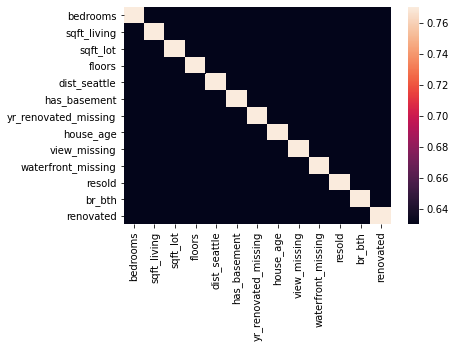

In [25]:
sns.heatmap(housing_df[relevant_num_cols].corr().abs(), vmin=.7, vmax=0.7);

### Train test split

In [26]:
y = housing_df['price']
X = housing_df[relevant_num_cols+relevant_cat_col]

In [27]:
X.head()

,bedrooms,sqft_living,sqft_lot,floors,dist_seattle,has_basement,yr_renovated_missing,house_age,view_missing,waterfront_missing,resold,br_bth,renovated,waterfront,zipcode,view,condition,grade,city,neighborhood
1,3,1560,7352,1.0,23.845278,0,0,22,0,0,0,1.500000,0,NO,98001,NONE,Average,6 Low Average,Algona,NA
3,4,2020,6236,2.0,23.937193,0,1,12,0,0,0,1.600000,0,NO,98001,NONE,Average,7 Average,Algona,NA
10,4,2163,5883,2.0,24.319553,0,1,8,0,0,0,1.333333,0,NO,98001,NONE,Average,7 Average,Algona,NA
13,2,910,22000,1.0,24.019006,0,0,58,0,0,0,2.000000,0,NO,98001,NONE,Average,6 Low Average,Algona,NA
18,3,1390,16000,1.0,23.209001,0,0,54,0,0,0,3.000000,0,NO,98001,NONE,Good,6 Low Average,Algona,NA


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## One Hot Encoder

In [29]:
encoder = OneHotEncoder(handle_unknown='ignore',
                        categories='auto') #                        drop='if_binary',

ct = ColumnTransformer(transformers=[('ohe', encoder, relevant_cat_col)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [30]:
# Put encoder output into DataFrame
X_train = pd.DataFrame(X_train_enc.todense(), columns= ct.get_feature_names(), index=X_train.index)
X_test = pd.DataFrame(X_test_enc.todense(), columns= ct.get_feature_names(), index=X_test.index)

In [31]:
replace_dict = {
    'ohe__': '',
    'x0': 'waterfront',
    'x1': 'zip',
    'x2': 'view',
    'x3': 'condition',
    'x4': 'grade',
    'x5': 'city',
    'x6': 'neighborhood'
}

In [32]:
X_train.columns = cleaned_column_names(X_train.columns)

for key, value in replace_dict.items():
    X_train.columns = [ x.replace(key, value) for x in list(X_train.columns) ]

In [33]:
X_test.columns = cleaned_column_names(X_test.columns)

for key, value in replace_dict.items():
    X_test.columns = [ x.replace(key, value) for x in list(X_test.columns) ]

In [34]:
train_df = pd.concat([X_train,y_train], axis=1)

In [35]:
def build_model(X_train, X_test, y_train, y_test):
    
    """
    Build a regression model
    
    """
    
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    R2_train = lr.score(X_train,y_train)
    R2_test = lr.score(X_test,y_test)


    yhat_train = lr.predict(X_train)
    train_rmse = mean_squared_error(y_train, yhat_train, squared = False)

    yhat_test = lr.predict(X_test)
    test_rmse = mean_squared_error(y_test, yhat_test, squared = False)
    
    print(f'Train R2: {lr.score(X_train,y_train)}')
    print(f'Test R2: {lr.score(X_test,y_test)}')
    print(f'Train RMSE: {train_rmse}')
    print(f'Test RMSE: {test_rmse}')
    
    return R2_train, R2_test, train_rmse, test_rmse


In [36]:
model_base_cols = ['sqft_living', 'bedrooms']

Xbase_train = X_train[model_base_cols]
Xbase_test = X_test[model_base_cols]

model_base_r2_train, model_base_r2_test, train_rmse, test_rmse = build_model(Xbase_train, Xbase_test, y_train, y_test)

Train R2: 0.5077862105659562
Test R2: 0.5046145987226243
Train RMSE: 256307.81232314883
Test RMSE: 261392.48743150264


In [37]:
model_base_formula = 'price ~ sqft_living + bedrooms'

In [38]:
model_base_mod = ols(model_base_formula, train_df).fit()
model_base_mod_summary = model_base_mod.summary()
model_base_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     7462.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:46:33   Log-Likelihood:            -2.0073e+05
No. Observations:               14469   AIC:                         4.015e+05
Df Residuals:                   14466   BIC:                         4.015e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    7.832e+04   8014.377      9.773      0.000    6.26e+04     9.4e+04
sqft_living   312.3635      2.838    110.074      0.000     306.801     317.926
bedrooms     -5.52e+04   2787.280    -19.805      0.000   -6.07e+04   -4.97e+04
==============================================================================
Omnibus:                     9485.512   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           299522.856
Skew:                           2.682   Prob(JB):                         0.00
Kurtosis:                      24.634   Cond. No.                     8.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
model_base_mod.params

Intercept      78320.809775
sqft_living      312.363498
bedrooms      -55202.082783
dtype: float64

In [40]:
model_1_cols = ['sqft_living', 'bedrooms', 'renovated', 'house_age', 'grade_10verygood', 'grade_11excellent', 'grade_12luxury', 'grade_13mansion', 
                   'grade_3poor', 'grade_4low', 'grade_5fair', 'grade_6lowaverage', 'grade_8good', 'grade_9better']

X1_train = X_train[model_1_cols]
X1_test = X_test[model_1_cols]

model_1_r2_train, model_1_r2_test, train_rmse, test_rmse = build_model(X1_train, X1_test, y_train, y_test)

Train R2: 0.6324494751299137
Test R2: 0.6452679034740165
Train RMSE: 221484.57168204186
Test RMSE: 221193.18511148528


In [41]:
# drop 'grade_7average' 
model_1_formula = model_base_formula + " + \
'renovated', 'house_age', \
'grade_10verygood', 'grade_11excellent', 'grade_12luxury', 'grade_13mansion', \
'grade_3poor', 'grade_4low', 'grade_5fair', 'grade_6lowaverage', \
'grade_8good', 'grade_9better'\
"

In [42]:
model_1_formula = model_1_formula.replace("'", "").replace(',', " + ")

In [43]:
print(model_1_formula)

price ~ sqft_living + bedrooms + renovated +  house_age +  grade_10verygood +  grade_11excellent +  grade_12luxury +  grade_13mansion +  grade_3poor +  grade_4low +  grade_5fair +  grade_6lowaverage +  grade_8good +  grade_9better


In [44]:
model_1_mod = ols(model_1_formula, train_df).fit()
model_1_mod_summary = model_1_mod.summary()
model_1_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     1777.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:46:33   Log-Likelihood:            -1.9862e+05
No. Observations:               14469   AIC:                         3.973e+05
Df Residuals:                   14454   BIC:                         3.974e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.042e+04   8533.169      2.393      0.017    3690.738    3.71e+04
sqft_living         178.5147      3.755     47.542      0.000     171.155     185.875
bedrooms          -2.593e+04   2507.289    -10.340      0.000   -3.08e+04    -2.1e+04
renovated          4.573e+04   2.09e+04      2.184      0.029    4678.761    8.68e+04
house_age          3276.4880     72.203     45.379      0.000    3134.961    3418.015
grade_10verygood    4.49e+05   1.06e+04     42.392      0.000    4.28e+05     4.7e+05
grade_11excellent  7.191e+05   1.68e+04     42.848      0.000    6.86e+05    7.52e+05
grade_12luxury     1.208e+06   3.09e+04     39.130      0.000    1.15e+06    1.27e+06
grade_13mansion    2.211e+06   9.25e+04     23.896      0.000    2.03e+06    2.39e+06
grade_3poor       -1.366e+05   2.22e+05     -0.616      0.538   -5.71e+05    2.98e+05
grade_4low        -1.414e+05   4.98e+04     -2.837      0.005   -2.39e+05   -4.37e+04
grade_5fair       -1.478e+05   1.84e+04     -8.038      0.000   -1.84e+05   -1.12e+05
grade_6lowaverage  -9.86e+04   7005.736    -14.074      0.000   -1.12e+05   -8.49e+04
grade_8good        1.125e+05   4944.007     22.759      0.000    1.03e+05    1.22e+05
grade_9better      2.577e+05   7393.362     34.856      0.000    2.43e+05    2.72e+05
==============================================================================
Omnibus:                     9803.526   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           451722.191
Skew:                           2.686   Prob(JB):                         0.00
Kurtosis:                      29.841   Cond. No.                     2.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# the independent variables set
y, X = dmatrices(model_1_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,21.454666
1,sqft_living,3.494273
2,bedrooms,1.614960
3,renovated,1.009976
4,house_age,1.335793
5,grade_10verygood,1.692266
6,grade_11excellent,1.519918
7,grade_12luxury,1.218317
8,grade_13mansion,1.045282
9,grade_3poor,1.000838


In [46]:
model_2_cols = ['sqft_living', 'bedrooms', 'renovated', 'house_age', 'grade_10verygood', 'grade_11excellent', 'grade_12luxury', 'grade_13mansion', 
                'grade_3poor', 'grade_4low', 'grade_5fair', 'grade_6lowaverage', 'grade_8good', 'grade_9better',
                'waterfront_yes', 'view_average', 'view_excellent', 'view_fair', 'view_good']

X2_train = X_train[model_2_cols]
X2_test = X_test[model_2_cols]

model_2_r2_train, model_2_r2_test, train_rmse, test_rmse = build_model(X2_train, X2_test, y_train, y_test)

Train R2: 0.6701286983460104
Test R2: 0.6743158471010332
Train RMSE: 209824.99560746498
Test RMSE: 211943.3590738888


In [47]:
model_2_formula = model_1_formula + " + \
'waterfront_yes', 'view_average', 'view_excellent', 'view_fair', 'view_good'"

In [48]:
model_2_formula = model_2_formula.replace("'", "").replace(',', " + ")

In [49]:
model_2_mod = ols(model_2_formula, train_df).fit()
model_2_mod_summary = model_2_mod.summary()
model_2_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     1545.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:46:33   Log-Likelihood:            -1.9783e+05
No. Observations:               14469   AIC:                         3.957e+05
Df Residuals:                   14449   BIC:                         3.959e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.838e+04   8118.057      4.728      0.000    2.25e+04    5.43e+04
sqft_living         158.8125      3.610     43.994      0.000     151.737     165.888
bedrooms          -1.746e+04   2386.704     -7.314      0.000   -2.21e+04   -1.28e+04
renovated          4.902e+04   1.98e+04      2.470      0.014    1.01e+04    8.79e+04
house_age          2913.9333     69.689     41.814      0.000    2777.335    3050.532
grade_10verygood    4.28e+05   1.01e+04     42.508      0.000    4.08e+05    4.48e+05
grade_11excellent  6.869e+05   1.59e+04     43.082      0.000    6.56e+05    7.18e+05
grade_12luxury     1.167e+06   2.94e+04     39.758      0.000    1.11e+06    1.22e+06
grade_13mansion     2.21e+06   8.78e+04     25.160      0.000    2.04e+06    2.38e+06
grade_3poor       -1.183e+05    2.1e+05     -0.563      0.573    -5.3e+05    2.93e+05
grade_4low        -1.409e+05   4.72e+04     -2.982      0.003   -2.33e+05   -4.83e+04
grade_5fair       -1.554e+05   1.74e+04     -8.917      0.000    -1.9e+05   -1.21e+05
grade_6lowaverage -9.778e+04   6639.612    -14.727      0.000   -1.11e+05   -8.48e+04
grade_8good        1.067e+05   4699.997     22.701      0.000    9.75e+04    1.16e+05
grade_9better      2.499e+05   7028.524     35.553      0.000    2.36e+05    2.64e+05
waterfront_yes     6.109e+05   2.57e+04     23.810      0.000    5.61e+05    6.61e+05
view_average       5.495e+04   8583.772      6.401      0.000    3.81e+04    7.18e+04
view_excellent     2.422e+05   1.75e+04     13.859      0.000    2.08e+05    2.76e+05
view_fair          1.297e+05   1.44e+04      8.973      0.000    1.01e+05    1.58e+05
view_good          1.117e+05   1.16e+04      9.634      0.000    8.89e+04    1.34e+05
==============================================================================
Omnibus:                     8175.984   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           288459.861
Skew:                           2.115   Prob(JB):                         0.00
Kurtosis:                      24.461   Cond. No.                     2.74e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
y, X = dmatrices(model_2_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,21.628557
1,sqft_living,3.597229
2,bedrooms,1.629943
3,renovated,1.010398
4,house_age,1.386032
5,grade_10verygood,1.703415
6,grade_11excellent,1.527942
7,grade_12luxury,1.225857
8,grade_13mansion,1.049505
9,grade_3poor,1.000848


In [51]:
model_3_cols = ['sqft_living', 'bedrooms', 'renovated', 'house_age', 'grade_10verygood', 'grade_11excellent', 'grade_12luxury', 'grade_13mansion', 
                'grade_3poor', 'grade_4low', 'grade_5fair', 'grade_6lowaverage', 'grade_8good', 'grade_9better',
                'waterfront_yes', 'view_average', 'view_excellent', 'view_fair', 'view_good',
                'dist_seattle', 'neighborhood_ballard', 'neighborhood_beaconhill', 'neighborhood_capitolhill', 
                'neighborhood_cascade', 'neighborhood_centralarea', 'neighborhood_delridge', 
                'neighborhood_downtown', 'neighborhood_greaterduwamish', 'neighborhood_interbay', 
                'neighborhood_lakecity', 'neighborhood_magnolia', 'neighborhood_northcentral', 
                'neighborhood_northeast', 'neighborhood_northgate', 'neighborhood_northwest', 
                'neighborhood_queenanne', 'neighborhood_rainiervalley', 'neighborhood_sewardpark', 
                'neighborhood_universitydistrict', 'neighborhood_westseattle']

X3_train = X_train[model_3_cols]
X3_test = X_test[model_3_cols]

model_3_r2_train, model_3_r2_test, train_rmse, test_rmse = build_model(X3_train, X3_test, y_train, y_test)

Train R2: 0.7457573020375254
Test R2: 0.7474142702554982
Train RMSE: 184208.3022309081
Test RMSE: 186649.10203977252


In [52]:
model_3_formula = model_2_formula + " + \
        'dist_seattle', \
        'neighborhood_ballard', 'neighborhood_beaconhill', \
        'neighborhood_capitolhill', 'neighborhood_cascade', \
        'neighborhood_centralarea', 'neighborhood_delridge', \
        'neighborhood_downtown', 'neighborhood_greaterduwamish', \
        'neighborhood_interbay', 'neighborhood_lakecity', \
        'neighborhood_magnolia', 'neighborhood_northcentral', \
        'neighborhood_northeast', 'neighborhood_northgate', \
        'neighborhood_northwest', 'neighborhood_queenanne', \
        'neighborhood_rainiervalley', 'neighborhood_sewardpark', \
        'neighborhood_universitydistrict', 'neighborhood_westseattle' \
"

In [53]:
model_3_formula = model_3_formula.replace("'", "").replace(',', " + ")

In [54]:
model_3_mod = ols(model_3_formula, train_df).fit()
model_3_mod_summary = model_3_mod.summary()
model_3_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     1058.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:46:33   Log-Likelihood:            -1.9595e+05
No. Observations:               14469   AIC:                         3.920e+05
Df Residuals:                   14428   BIC:                         3.923e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        2.744e+05   9290.223     29.532      0.000    2.56e+05    2.93e+05
sqft_living                       179.7045      3.207     56.035      0.000     173.418     185.991
bedrooms                        -1.523e+04   2113.146     -7.205      0.000   -1.94e+04   -1.11e+04
renovated                        5.093e+04   1.75e+04      2.914      0.004    1.67e+04    8.52e+04
house_age                         872.4309     70.225     12.423      0.000     734.781    1010.081
grade_10verygood                 3.217e+05   9011.273     35.705      0.000    3.04e+05    3.39e+05
grade_11excellent                5.533e+05   1.42e+04     39.019      0.000    5.25e+05    5.81e+05
grade_12luxury                   1.005e+06   2.59e+04     38.749      0.000    9.54e+05    1.06e+06
grade_13mansion                  1.938e+06   7.74e+04     25.035      0.000    1.79e+06    2.09e+06
grade_3poor                      3.003e+05   1.85e+05      1.626      0.104   -6.17e+04    6.62e+05
grade_4low                      -1.023e+04   4.16e+04     -0.246      0.806   -9.17e+04    7.13e+04
grade_5fair                     -4.005e+04   1.54e+04     -2.593      0.010   -7.03e+04   -9772.114
grade_6lowaverage               -3.323e+04   5991.008     -5.546      0.000    -4.5e+04   -2.15e+04
grade_8good                      5.573e+04   4216.177     13.217      0.000    4.75e+04     6.4e+04
grade_9better                    1.664e+05   6330.180     26.280      0.000    1.54e+05    1.79e+05
waterfront_yes                   6.329e+05   2.26e+04     28.045      0.000    5.89e+05    6.77e+05
view_average                     5.558e+04   7582.043      7.330      0.000    4.07e+04    7.04e+04
view_excellent                   2.427e+05   1.54e+04     15.758      0.000    2.13e+05    2.73e+05
view_fair                         1.02e+05   1.28e+04      7.964      0.000    7.69e+04    1.27e+05
view_good                          1.2e+05   1.02e+04     11.721      0.000    9.99e+04     1.4e+05
dist_seattle                    -1.439e+04    320.784    -44.855      0.000    -1.5e+04   -1.38e+04
neighborhood_ballard             2.828e+04   1.06e+04      2.665      0.008    7480.729    4.91e+04
neighborhood_beaconhill         -1.426e+05   1.41e+04    -10.111      0.000    -1.7e+05   -1.15e+05
neighborhood_capitolhill         2.087e+05   1.46e+04     14.271      0.000     1.8e+05    2.37e+05
neighborhood_cascade             6.427e+04   3.52e+04      1.823      0.068   -4823.870    1.33e+05
neighborhood_centralarea         2.353e+04   1.12e+04      2.106      0.035    1630.931    4.54e+04
neighborhood_delridge           -1.264e+05   1.08e+04    -11.715      0.000   -1.48e+05   -1.05e+05
neighborhood_downtown           -4.442e+04   1.85e+05     -0.241      0.810   -4.06

In [55]:
model_3_mod.params

Intercept                          2.743632e+05
sqft_living                        1.797045e+02
bedrooms                          -1.522608e+04
renovated                          5.092926e+04
house_age                          8.724309e+02
grade_10verygood                   3.217438e+05
grade_11excellent                  5.532596e+05
grade_12luxury                     1.004524e+06
grade_13mansion                    1.937667e+06
grade_3poor                        3.003205e+05
grade_4low                        -1.022591e+04
grade_5fair                       -4.004622e+04
grade_6lowaverage                 -3.322535e+04
grade_8good                        5.572512e+04
grade_9better                      1.663579e+05
waterfront_yes                     6.329475e+05
view_average                       5.557599e+04
view_excellent                     2.427396e+05
view_fair                          1.019675e+05
view_good                          1.199618e+05
dist_seattle                      -1.438

In [56]:
y, X = dmatrices(model_3_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,36.697797
1,sqft_living,3.678246
2,bedrooms,1.655383
3,renovated,1.015081
4,house_age,1.823455
5,grade_10verygood,1.767345
6,grade_11excellent,1.565483
7,grade_12luxury,1.238760
8,grade_13mansion,1.055846
9,grade_3poor,1.002349


In [57]:
model_4_cols = ['sqft_living', 'bedrooms', 'renovated', 'house_age', 'grade_10verygood', 'grade_11excellent', 'grade_12luxury', 'grade_13mansion', 
                'grade_3poor', 'grade_4low', 'grade_5fair', 'grade_6lowaverage', 'grade_8good', 'grade_9better',
                'waterfront_yes', 'view_average', 'view_excellent', 'view_fair', 'view_good',
                'dist_seattle', 'neighborhood_ballard', 'neighborhood_beaconhill', 'neighborhood_capitolhill', 
                'neighborhood_cascade', 'neighborhood_centralarea', 'neighborhood_delridge', 
                'neighborhood_downtown', 'neighborhood_greaterduwamish', 'neighborhood_interbay', 
                'neighborhood_lakecity', 'neighborhood_magnolia', 'neighborhood_northcentral', 
                'neighborhood_northeast', 'neighborhood_northgate', 'neighborhood_northwest', 
                'neighborhood_queenanne', 'neighborhood_rainiervalley', 'neighborhood_sewardpark', 
                'neighborhood_universitydistrict', 'neighborhood_westseattle',
                'zip_98002','zip_98003','zip_98004','zip_98005','zip_98006','zip_98007','zip_98008','zip_98010',
                'zip_98011','zip_98014','zip_98019','zip_98022','zip_98023','zip_98024','zip_98027','zip_98028',
                'zip_98029','zip_98030','zip_98031','zip_98032','zip_98033','zip_98034','zip_98038','zip_98039',
                'zip_98040','zip_98042','zip_98045','zip_98052','zip_98053','zip_98055','zip_98056','zip_98058',
                'zip_98059','zip_98065','zip_98070','zip_98072','zip_98074','zip_98075','zip_98077','zip_98092',
                'zip_98102','zip_98103','zip_98105','zip_98106','zip_98107','zip_98108','zip_98109','zip_98112',
                'zip_98115','zip_98116','zip_98117','zip_98118','zip_98119','zip_98122','zip_98125','zip_98126',
                'zip_98133','zip_98136','zip_98144','zip_98146','zip_98148','zip_98155','zip_98166','zip_98168',
                'zip_98177','zip_98178','zip_98188','zip_98198','zip_98199']

X4_train = X_train[model_4_cols]
X4_test = X_test[model_4_cols]

model_4_r2_train, model_4_r2_test, train_rmse, test_rmse = build_model(X4_train, X4_test, y_train, y_test)

Train R2: 0.8338662057554318
Test R2: 0.8292357587141828
Train RMSE: 148906.6000219651
Test RMSE: 153468.75359185


In [58]:
model_4_formula = model_3_formula + " + \
zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,\
zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,\
zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98052,zip_98053,\
zip_98055,zip_98056,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,\
zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,\
zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,\
zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199\
"

In [59]:
model_4_formula = model_4_formula.replace("'", "").replace(',', " + ")

In [60]:
model_4_mod = ols(model_4_formula, train_df).fit()
model_4_mod_summary = model_4_mod.summary()
model_4_mod_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     661.2
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:46:35   Log-Likelihood:            -1.9287e+05
No. Observations:               14469   AIC:                         3.860e+05
Df Residuals:                   14359   BIC:                         3.868e+05
Df Model:                         109                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        1.342e+05   2.37e+04      5.652      0.000    8.77e+04    1.81e+05
sqft_living                       163.0242      2.643     61.673      0.000     157.843     168.206
bedrooms                        -9910.0557   1731.548     -5.723      0.000   -1.33e+04   -6515.998
renovated                        6.232e+04   1.42e+04      4.391      0.000    3.45e+04    9.01e+04
house_age                         553.4883     59.111      9.363      0.000     437.622     669.354
grade_10verygood                 2.455e+05   7573.055     32.424      0.000    2.31e+05     2.6e+05
grade_11excellent                4.365e+05   1.17e+04     37.235      0.000    4.14e+05     4.6e+05
grade_12luxury                   8.317e+05   2.13e+04     39.014      0.000     7.9e+05    8.73e+05
grade_13mansion                  1.798e+06   6.31e+04     28.498      0.000    1.67e+06    1.92e+06
grade_3poor                      1.508e+05    1.5e+05      1.005      0.315   -1.43e+05    4.45e+05
grade_4low                       2.027e+04   3.38e+04      0.599      0.549   -4.61e+04    8.66e+04
grade_5fair                     -1.103e+04   1.27e+04     -0.871      0.384   -3.59e+04    1.38e+04
grade_6lowaverage               -8041.4836   4960.827     -1.621      0.105   -1.78e+04    1682.379
grade_8good                      2.876e+04   3518.810      8.172      0.000    2.19e+04    3.57e+04
grade_9better                    1.129e+05   5294.371     21.322      0.000    1.03e+05    1.23e+05
waterfront_yes                   6.434e+05   1.86e+04     34.556      0.000    6.07e+05     6.8e+05
view_average                     6.735e+04   6249.899     10.776      0.000    5.51e+04    7.96e+04
view_excellent                   2.828e+05   1.27e+04     22.353      0.000    2.58e+05    3.08e+05
view_fair                        6.953e+04   1.05e+04      6.637      0.000     4.9e+04    9.01e+04
view_good                        1.451e+05   8427.529     17.214      0.000    1.29e+05    1.62e+05
dist_seattle                    -7934.8539    956.396     -8.297      0.000   -9809.514   -6060.193
neighborhood_ballard             5.915e+04   2.02e+04      2.933      0.003    1.96e+04    9.87e+04
neighborhood_beaconhill         -5.254e+04   2.78e+04     -1.887      0.059   -1.07e+05    2036.062
neighborhood_capitolhill         5374.0180   3.66e+04      0.147      0.883   -6.63e+04    7.71e+04
neighborhood_cascade            -1.397e+04   5.15e+04     -0.271      0.786   -1.15e+05     8.7e+04
neighborhood_centralarea        -2.542e+04   3.05e+04     -0.835      0.404   -8.51e+04    3.43e+04
neighborhood_delridge            1.228e+04   2.44e+04      0.503      0.615   -3.55e+04    6.01e+04
neighborhood_downtown           -7.585e+04   1.53e+05     -0.496      0.620   -3.76

In [61]:
y, X = dmatrices(model_4_formula, data=train_df, return_type='dataframe')

# VIF dataframe
vif = pd.DataFrame()
vif["feature"] = X.columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
  
display(vif)

,feature,VIF
0,Intercept,365.190417
1,sqft_living,3.805948
2,bedrooms,1.692846
3,renovated,1.019692
4,house_age,1.967726
...,...,...
105,zip_98177,3.008296
106,zip_98178,3.169129
107,zip_98188,1.634845
108,zip_98198,2.006647


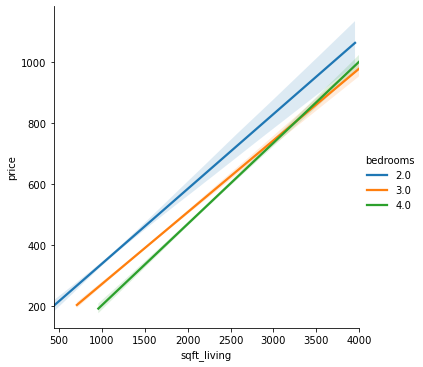

In [99]:
filt = (train_df['bedrooms'].isin([2,3,4])) & (train_df['price'] <= 2000000) & (train_df['sqft_living'] <=4000)
cleaner_train_df = train_df[filt]
cleaner_train_df['price'] = cleaner_train_df['price'] / 1000
#fig, ax = plt.subplots(1)
sns.lmplot(y='price', x='sqft_living', hue='bedrooms', data=cleaner_train_df, scatter=False)
#ax.ticklabel_format(style='plain', axis='y');   #scilimits=(6,6));

plt.savefig('../Images/lmplot_price-vs-sqft_living-by_bedrooms.jpg', transparent = False, bbox_inches="tight");

In [84]:
cleaner_train_df.head()

,waterfront_no,waterfront_yes,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,...,dist_seattle,has_basement,yr_renovated_missing,house_age,view_missing,waterfront_missing,resold,br_bth,renovated,price
16715,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.227898,0.0,0.0,8.0,0.0,0.0,0.0,0.800000,0.0,549.0
128,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.266327,0.0,0.0,17.0,0.0,0.0,0.0,1.714286,0.0,285.0
8422,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.551542,0.0,0.0,9.0,0.0,0.0,0.0,1.200000,0.0,300.0
1221,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,8.444660,1.0,0.0,36.0,0.0,0.0,0.0,1.200000,0.0,530.0
8228,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.465062,0.0,1.0,34.0,0.0,1.0,0.0,1.714286,0.0,140.0


In [96]:
cleaner_train_df['grade_ordinal'] = (cleaner_train_df['grade_3poor'] * 3) + (cleaner_train_df['grade_4low'] * 4) + \
(cleaner_train_df['grade_5fair'] * 5) + (cleaner_train_df['grade_6lowaverage'] * 6) + \
(cleaner_train_df['grade_7average'] * 7) + (cleaner_train_df['grade_8good'] * 8) + \
(cleaner_train_df['grade_9better'] * 9) + (cleaner_train_df['grade_10verygood'] * 10) + \
(cleaner_train_df['grade_11excellent'] * 11) + (cleaner_train_df['grade_12luxury'] * 12) + \
(cleaner_train_df['grade_13mansion'] * 13)

In [97]:
cleaner_train_df['grade_ordinal'].describe()

count    12668.000000
mean         7.548784
std          1.038641
min          4.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         12.000000
Name: grade_ordinal, dtype: float64

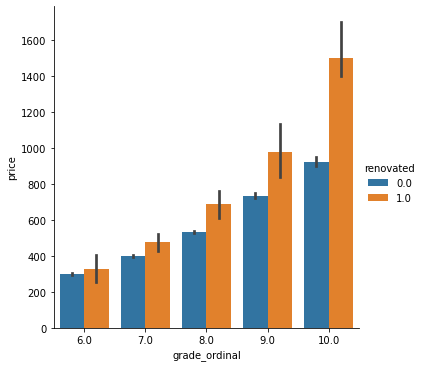

In [98]:
filt = (cleaner_train_df['grade_ordinal'] >= 6) & (cleaner_train_df['grade_ordinal'] <= 10)

sns.catplot(x="grade_ordinal", y="price", hue="renovated", kind="bar", data=cleaner_train_df[filt])
plt.savefig('../Images/barplot_price-vs-grade-by-renovated.jpg', transparent = False, bbox_inches="tight");